# Population analysis

## Defining an experiment over a small group from the open-source MMASH study
Link to study: Rossi, A., Da Pozzo, E., Menicagli, D., Tremolanti, C., Priami, C., Sirbu, A., Clifton, D., Martini, C., & Morelli, D. (2020). Multilevel Monitoring of Activity and Sleep in Healthy People (version 1.0.0). PhysioNet. https://doi.org/10.13026/cerq-fc86.

### 1. Importing dependencies

In [1]:
#HypnosPy
from hypnospy import Wearable, Diary
from hypnospy.data import RawProcessing
from hypnospy.analysis import NonWearingDetector, SleepBoudaryDetector, Validator, Viewer
from hypnospy import Experiment
#Evaluation
from sklearn.metrics import mean_squared_error, cohen_kappa_score
#Other packages
import tempfile
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm

### 2. Defining an experiment function to process all subject data

In [2]:
def load_experiment(data_path, diary_path, start_hour):
    # Configure an Experiment
    exp = Experiment()

    # Iterates over a set of files in a directory.
    # Unfortunately, we have to do it manually with RawProcessing because we are modifying the annotations
    for file in glob(data_path):
        pp = RawProcessing(file,
                           # HR information
                           col_for_hr="HR",
                           # Activity information
                           cols_for_activity=["Axis1", "Axis2", "Axis3"],
                           is_act_count=False,
                           # Datetime information
                           col_for_datetime="time",
                           strftime="%Y-%b-%d %H:%M:%S",
                           # Participant information
                           col_for_pid="pid")

        w = Wearable(pp)  # Creates a wearable from a pp object
        exp.add_wearable(w)

    # Set frequency for every wearable in the collection
    # exp.set_freq_in_secs(5)

    # Changing the hour the experiment starts from midnight (0) to 3pm (15)
    exp.change_start_hour_for_experiment_day(start_hour)

    diary = Diary().from_file(diary_path)
    exp.add_diary(diary)

    return exp

### 3. Defining the parameters of the experiment

In [3]:
# Path to find the wearables data and the sleep diaries
diary_path = "./data/examples_mmash/diary/mmash_diary.csv"
data_path = "./data/examples_mmash/*.csv"

# Parameters for the HypnosPy HR-based sleep algorithm
hr_quantile = 0.4
hr_min_window_length = 40
hr_merge_blocks = 180

hr_volarity = 5
#Time to consider as start and end of each experiment day - if equal the sleep labelling occurs
#over the entire 24 hours
start_hour = 15
end_hour = 15

#Giving the experiment a number
exp_id = 0

### 4. Validating data completeness

In [4]:
exp = load_experiment(data_path, diary_path, start_hour)
exp.fill_no_activity(-0.0001)

va = Validator(exp)
# Do diaries exist for all subjects? Remove those who don't have them
va.remove_wearables_without_diary()

# Flag times with less activity than set threshold, or non-wearing periods
va.flag_epoch_physical_activity_less_than(min_activity_threshold=0)
va.flag_epoch_null_cols(col_list=["hyp_act_x"])
va.flag_day_max_nonwearing(max_non_wear_minutes_per_day=3*60)

va.flag_day_if_invalid_epochs_larger_than(max_invalid_minutes_per_day=5 * 60)
# Flag when the diary annotation is missing
va.flag_day_without_diary()

# Accounting for removed days and subjects (referred to as wearables)
n_removed_days = va.remove_flagged_days()
print("Removed %d days (non wearing)." % n_removed_days)
n_users = va.remove_wearables_without_valid_days()
print("Removed %d wearables." % n_users)

Removed 3 days (non wearing).
Removed 0 wearables.


### 5. Sleep Labelling

Using 3 algorithms:
* HypnosPy - HR-based
* Adapted van Hees - angle-based
* Adapted van Hess - angle-based, using pitch and roll

In [5]:
sbd = SleepBoudaryDetector(exp)

sbd.detect_sleep_boundaries(strategy="hr", output_col="hyp_sleep_period_hr", hr_quantile=hr_quantile,
                                hr_volarity_threshold=hr_volarity, hr_rolling_win_in_minutes=5,
                                hr_sleep_search_window=(start_hour, end_hour),
                                hr_min_window_length_in_minutes=hr_min_window_length,
                                hr_volatility_window_in_minutes=10, hr_merge_blocks_gap_time_in_min=hr_merge_blocks,
                                hr_sleep_only_in_sleep_search_window=True, hr_only_largest_sleep_period=True)

sbd.detect_sleep_boundaries(strategy="adapted_van_hees", output_col="hyp_sleep_period_vanhees", angle_cols=[],
                                angle_use_triaxial_activity=True, angle_start_hour=start_hour, angle_quantile=0.1,
                                angle_minimum_len_in_minutes=30, angle_merge_tolerance_in_minutes=60)

sbd.detect_sleep_boundaries(strategy="adapted_van_hees", output_col="hyp_sleep_period_vanheespr",
                                angle_cols=["pitch", "roll"], angle_use_triaxial_activity=False,
                                angle_start_hour=start_hour, angle_quantile=0.1, angle_minimum_len_in_minutes=30,
                                angle_merge_tolerance_in_minutes=60)

### 6. Evaluating sleep metrics

For all 3 algorithms used we calculate:
- TST (total sleep time)
- Sleep onset
- Sleep offset (awakening)

Other sleep quality metrics are available using the SleepMetrics class.

Evaluation metrics used:
- MSE (mean squared error) - 0 if all epoch labels are identical between algorithm and ground truth, 1 if all are different
- Cohen's kappa

In [20]:
df_acc = []
mses = {}
cohens = {}

print("Calculating evaluation measures...")
for w in exp.get_all_wearables():

    if w.data.empty:
        print("Data for PID %s is empty!" % w.get_pid())
        continue

    sleep = {}
    sleep["diary"] = w.data[w.diary_sleep].astype(int)
    sleep["hr"] = w.data["hyp_sleep_period_hr"].astype(int)
    sleep["vanhees"] = w.data["hyp_sleep_period_vanhees"].astype(int)
    sleep["vanheespr"] = w.data["hyp_sleep_period_vanheespr"].astype(int)

    if sleep["diary"].shape[0] == 0:
        continue

    for comb in ["diary_hr", "diary_vanhees", "hr_vanhees", "diary_vanheespr", "hr_vanheespr", "vanhees_vanheespr"]:
        a, b = comb.split("_")
        mses[comb] = mean_squared_error(sleep[a], sleep[b])
        cohens[comb] = cohen_kappa_score(sleep[a], sleep[b])

    tst_diary = w.get_total_sleep_time_per_day(based_on_diary=True)
    tst_hr = w.get_total_sleep_time_per_day(sleep_col="hyp_sleep_period_hr")
    tst_vanhees = w.get_total_sleep_time_per_day(sleep_col="hyp_sleep_period_vanhees")
    tst_vanheespr = w.get_total_sleep_time_per_day(sleep_col="hyp_sleep_period_vanheespr")

    onset_diary = w.get_onset_sleep_time_per_day(based_on_diary=True)
    onset_diary.name = "onset_diary"
    onset_hr = w.get_onset_sleep_time_per_day(sleep_col="hyp_sleep_period_hr")
    onset_hr.name = "onset_hr"
    onset_vanhees = w.get_onset_sleep_time_per_day(sleep_col="hyp_sleep_period_vanhees")
    onset_vanhees.name = "onset_vanhees"
    onset_vanheespr = w.get_onset_sleep_time_per_day(sleep_col="hyp_sleep_period_vanheespr")
    onset_vanheespr.name = "onset_vanheespr"

    offset_diary = w.get_offset_sleep_time_per_day(based_on_diary=True)
    offset_diary.name = "offset_diary"
    offset_hr = w.get_offset_sleep_time_per_day(sleep_col="hyp_sleep_period_hr")
    offset_hr.name = "offset_hr"
    offset_vanhees = w.get_offset_sleep_time_per_day(sleep_col="hyp_sleep_period_vanhees")
    offset_vanhees.name = "offset_vanhees"
    offset_vanheespr = w.get_offset_sleep_time_per_day(sleep_col="hyp_sleep_period_vanheespr")
    offset_vanheespr.name = "offset_vanheespr"
    # Putting together the data for each subject / wearable 
    df_res = pd.concat((onset_hr, onset_diary, onset_vanhees, onset_vanheespr,
                        offset_hr, offset_diary, offset_vanhees, offset_vanheespr,
                        tst_diary, tst_hr, tst_vanhees, tst_vanheespr), axis=1)

    df_res["pid"] = w.get_pid()
    
    for comb in ["diary_hr", "diary_vanhees", "hr_vanhees", "diary_vanheespr", "hr_vanheespr", "vanhees_vanheespr"]:
        df_res["mse_" + comb] = mses[comb]
        df_res["cohens_" + comb] = cohens[comb]
    # Appending each subject's dataframe into a list of all subject data ready for population analyses
    df_acc.append(df_res)

Calculating evaluation measures...
                       onset_hr         onset_diary       onset_vanhees  \
hyp_exp_day                                                               
0           2020-01-02 00:44:05 2020-01-02 00:46:00 2020-01-02 00:44:20   

                onset_vanheespr           offset_hr        offset_diary  \
hyp_exp_day                                                               
0           2020-01-02 00:44:25 2020-01-02 07:34:40 2020-01-02 03:31:00   

                 offset_vanhees    offset_vanheespr  hyp_diary_sleep  \
hyp_exp_day                                                            
0           2020-01-02 07:50:10 2020-01-02 07:50:15       165.083333   

             hyp_sleep_period_hr  ...  mse_diary_vanhees  \
hyp_exp_day                       ...                      
0                     410.666667  ...           0.231715   

             cohens_diary_vanhees mse_hr_vanhees  cohens_hr_vanhees  \
hyp_exp_day                                 

In [24]:
#Check out the format of the experiment output dataframe
print(df_acc[0].columns)

Index(['onset_hr', 'onset_diary', 'onset_vanhees', 'onset_vanheespr',
       'offset_hr', 'offset_diary', 'offset_vanhees', 'offset_vanheespr',
       'hyp_diary_sleep', 'hyp_sleep_period_hr', 'hyp_sleep_period_vanhees',
       'hyp_sleep_period_vanheespr', 'pid', 'mse_diary_hr', 'cohens_diary_hr',
       'mse_diary_vanhees', 'cohens_diary_vanhees', 'mse_hr_vanhees',
       'cohens_hr_vanhees', 'mse_diary_vanheespr', 'cohens_diary_vanheespr',
       'mse_hr_vanheespr', 'cohens_hr_vanheespr', 'mse_vanhees_vanheespr',
       'cohens_vanhees_vanheespr'],
      dtype='object')


### 7. Recording the results of the experiment

In [15]:
exp_id += 1
#df_acc = pd.concat(df_acc)
df_acc["exp_id"] = exp_id
df_acc["quantile"] = hr_quantile
df_acc["window_lengths"] = hr_min_window_length
df_acc["time_merge_blocks"] = hr_merge_blocks

output_path = './data/examples_mmash/experiments'

df_acc.to_csv(os.path.join(output_path, "exp_%d.csv" % (exp_id)), index=False)

### 8. Visualizing the experiment

Use the Viewer class to plot the signals and sleep labels

C:\Users\mariu\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\mariu\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\mariu\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\mariu\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Suppor

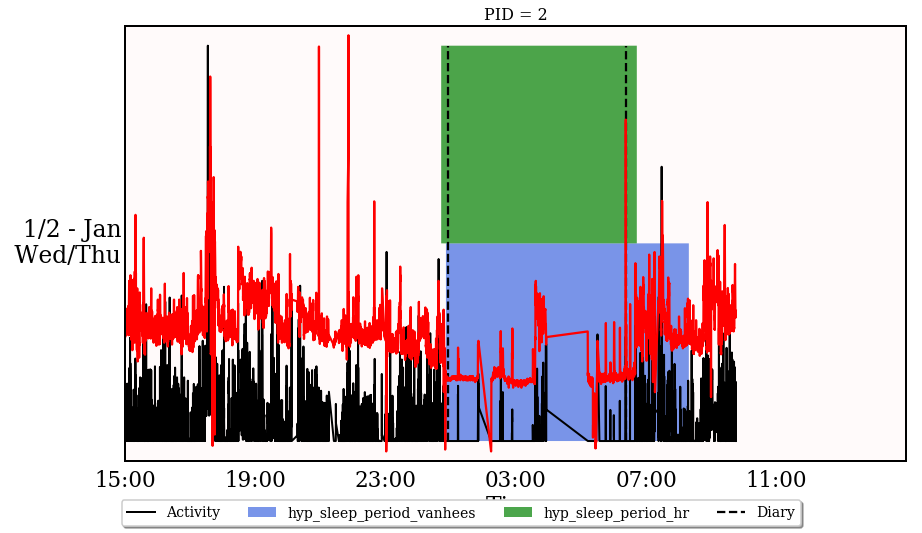

In [14]:
v = Viewer(w)

v.view_signals(["activity", "hr", "sleep", "diary"],
                sleep_cols=["hyp_sleep_period_vanhees", "hyp_sleep_period_hr"],
              alphas={'sleep': 0.3})